### Notebook purpose: Comparing output of TOM12_TJ_T001 and TOM12_TJ_M001

- no spinup, years 1948-2020
- T001 has CLIO physics and NCEP
- M001 has CORE physics and MetOffice/noOzone
- rest should be the same


### (very) preliminary notes:
- T001/NCEP fresher accross the board in winter, something strange happens year 2010 or so-possibly an error in copying?
- TOO1 saltier in surface in midlatitudes (-60s) in summer? icemelt differences
- T001 warmer in northern southern ocean (50s) in both winter and summer
- appreciable temperature differences even at 4000m depth!
- in both summer & winter, T001 has more DIC at surface but less at depth?

In [114]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle

#import mapfxn as mf
#reload(mf)

plt.rcParams.update({'font.size': 10})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 10}

plt.rc('font', **font)

In [115]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


### understanding the meshmask

In [116]:

tnc = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
print('meshmask used: /gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
print('variables in meshmask:')
print()
print(tnc)

meshmask used: /gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc
variables in meshmask:

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    file_name: mesh_mask.nc
    TimeStamp: 28/02/2019 15:51:26 +0000
    dimensions(sizes): x(182), y(149), z(31), t(1)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 nav_lev(z), float64 time_counter(t), int8 tmask(t,z,y,x), int8 umask(t,z,y,x), int8 vmask(t,z,y,x), int8 fmask(t,z,y,x), int8 tmaskutil(t,y,x), int8 umaskutil(t,y,x), int8 vmaskutil(t,y,x), int8 fmaskutil(t,y,x), float32 glamt(t,y,x), float32 glamu(t,y,x), float32 glamv(t,y,x), float32 glamf(t,y,x), float32 gphit(t,y,x), float32 gphiu(t,y,x), float32 gphiv(t,y,x), float32 gphif(t,y,x), float64 e1t(t,y,x), float64 e1u(t,y,x), float64 e1v(t,y,x), float64 e1f(t,y,x), float64 e2t(t,y,x), float64 e2u(t,y,x), float64 e2v(t,y,x), float64 e2f(t,y,x), float64 ff(t,y,x), int16 mbathy(t,y,x), int16 m

(31,)


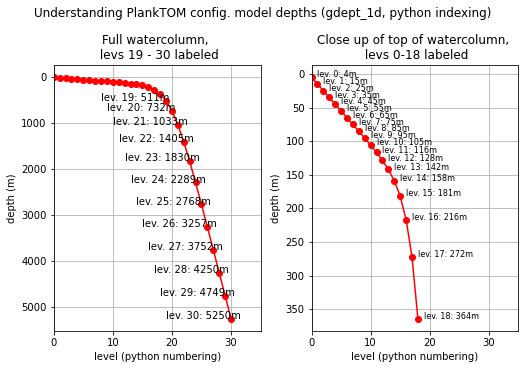

In [117]:
tnc = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')


tdepths = (tnc['gdept_1d'][0,:])
print(np.shape(tdepths))
tind = np.arange(0,len(tdepths),1)

fact = 0.37
fig, axs = plt.subplots(1,2, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(19,len(tdepths)):
    axs[0].text(i-11,tdepths[i],f'lev. {i}: {int(tdepths[i])}m')
axs[0].plot(tind,tdepths,'ro-')
axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_xlim([0,35])
axs[0].set_title('Full watercolumn, \n levs 19 - 30 labeled')

axs[1].plot(tind[0:19],tdepths[0:19],'ro-')
for i in range(0,19):
    axs[1].text(i+1,tdepths[i],f'lev. {i}: {int(tdepths[i])}m', fontsize = 8)
axs[1].invert_yaxis()
axs[1].grid()
axs[1].set_xlim([0,35])
axs[1].set_title('Close up of top of watercolumn, \n levs 0-18 labeled')

for i in range(0,2):
    axs[i].set_xlabel('level (python numbering)')
    axs[i].set_ylabel('depth (m)')

plt.suptitle('Understanding PlankTOM config. model depths (gdept_1d, python indexing)')
plt.tight_layout()

In [118]:
yrstart = 1990
yrend = 1990
trun = 'TOM12_TJ_T001'
ncnam = 'grid'
depth = 0
varnam = 'votemper'

def modoutput_bylat_winter_summer_quantav(yrstart, yrend, trun, ncnam,\
                                          varnam, topend = 37, verbose = False):

    # tnc = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    # tdepths = (tnc['gdept_1d'][0,:])
    # print(f'extracting var. {varnam} ({ncnam}) at lev. {depth} ({int(tdepths[depth])}m), yrs {yrstart}-{yrend}')

    
    yrs = np.arange(yrstart,yrend+1,1)
    tq_sum_bylat = np.zeros([31,topend,len(yrs)])
    tq_wint_bylat = np.zeros([31,topend,len(yrs)])
    
    rdir = '/gpfs/data/greenocean/software/runs/'
    print(len(yrs))
    for i in range(0,len(yrs)):
        yr = yrs[i]

        w = glob.glob(f'{rdir}{trun}/ORCA*{yr}*{ncnam}_T.nc')
        tnam = (w[0])
        if (i%20 == 0): 
            print(yr)
            print(tnam)
        tfil = nc.Dataset(tnam)
        if (i == 0) & verbose:
            print(tfil)
        tq = tfil[varnam]

        wint_tq = (tq[5:8,:,0:topend,:])
        sum1_tq = tq[0:2,:,0:topend,:]
        sum2_tq = np.zeros([1,31,topend,182])
        sum2_tq[:,:,:,:] = tq[11,:,0:topend,:]
        sum_tq = np.concatenate([sum1_tq,sum2_tq], axis =0 )
        sum_tq[sum_tq == 0]= np.nan; wint_tq[wint_tq ==0]= np.nan
        sum_mean = np.nanmean(np.nanmean(sum_tq, axis = 0),axis = 2)
        wint_mean = np.nanmean(np.nanmean(wint_tq, axis = 0),axis = 2)
        if verbose:
            plt.plot(sum_mean[:,20],tdepths, 'r-')
            plt.plot(wint_mean[:,20],tdepths, 'k-')
        tq_sum_bylat[:,:,i] = sum_mean
        tq_wint_bylat[:,:,i] = wint_mean
        
    return tq_sum_bylat, tq_wint_bylat
    

In [119]:
runhorse = False

if runhorse:
    now = datetime.now()
    yrstart = 1948; yrend = 2020; ncnam = 'ptrc'; trun = 'TOM12_TJ_T001'; varnam = 'DIC'
    tq_sum_bylat, tq_wint_bylat = modoutput_bylat_winter_summer_quantav(yrstart, yrend,\
                                      trun, ncnam, varnam)
    fn = f'./pkls/{trun}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint_bylat, open(fn, 'wb'))
    fn = f'./pkls/{trun}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum_bylat, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now) 
    
    now = datetime.now()
    yrstart = 1948; yrend = 2020; ncnam = 'grid'; trun = 'TOM12_TJ_T001'; varnam = 'votemper'
    tq_sum_bylat, tq_wint_bylat = modoutput_bylat_winter_summer_quantav(yrstart, yrend,\
                                      trun, ncnam, varnam)
    fn = f'./pkls/{trun}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint_bylat, open(fn, 'wb'))
    fn = f'./pkls/{trun}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum_bylat, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now)       
    
    yrstart = 1948; yrend = 2020; ncnam = 'grid'; trun = 'TOM12_TJ_T001'; varnam = 'vosaline'
    tq_sum_bylat, tq_wint_bylat = modoutput_bylat_winter_summer_quantav(yrstart, yrend,\
                                      trun, ncnam, varnam)
    fn = f'./pkls/{trun}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint_bylat, open(fn, 'wb'))
    fn = f'./pkls/{trun}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum_bylat, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now)   
    
    now = datetime.now()
    yrstart = 1948; yrend = 2020; ncnam = 'ptrc'; trun = 'TOM12_TJ_M001'; varnam = 'DIC'
    tq_sum_bylat, tq_wint_bylat = modoutput_bylat_winter_summer_quantav(yrstart, yrend,\
                                      trun, ncnam, varnam)
    fn = f'./pkls/{trun}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint_bylat, open(fn, 'wb'))
    fn = f'./pkls/{trun}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum_bylat, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now) 
    
    now = datetime.now()
    yrstart = 1948; yrend = 2020; ncnam = 'grid'; trun = 'TOM12_TJ_M001'; varnam = 'votemper'
    tq_sum_bylat, tq_wint_bylat = modoutput_bylat_winter_summer_quantav(yrstart, yrend,\
                                      trun, ncnam, varnam)
    fn = f'./pkls/{trun}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint_bylat, open(fn, 'wb'))
    fn = f'./pkls/{trun}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum_bylat, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now)       
    
    yrstart = 1948; yrend = 2020; ncnam = 'grid'; trun = 'TOM12_TJ_M001'; varnam = 'vosaline'
    tq_sum_bylat, tq_wint_bylat = modoutput_bylat_winter_summer_quantav(yrstart, yrend,\
                                      trun, ncnam, varnam)
    fn = f'./pkls/{trun}_{varnam}_wint_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_wint_bylat, open(fn, 'wb'))
    fn = f'./pkls/{trun}_{varnam}_sum_{yrstart}-{yrend}.pkl'
    pickle.dump(tq_sum_bylat, open(fn, 'wb'))
    now2 = datetime.now()
    print(now2-now)   

In [120]:
T001_DIC_sum = pickle.load(open('./pkls/TOM12_TJ_T001_DIC_sum_1948-2020.pkl', 'rb'))
T001_DIC_wint = pickle.load(open('./pkls/TOM12_TJ_T001_DIC_wint_1948-2020.pkl', 'rb'))
T001_votemper_sum = pickle.load(open('./pkls/TOM12_TJ_T001_votemper_sum_1948-2020.pkl', 'rb'))
T001_votemper_wint = pickle.load(open('./pkls/TOM12_TJ_T001_votemper_wint_1948-2020.pkl', 'rb'))
T001_vosaline_sum = pickle.load(open('./pkls/TOM12_TJ_T001_vosaline_sum_1948-2020.pkl', 'rb'))
T001_vosaline_wint = pickle.load(open('./pkls/TOM12_TJ_T001_vosaline_wint_1948-2020.pkl', 'rb'))

M001_DIC_sum = pickle.load(open('./pkls/TOM12_TJ_M001_DIC_sum_1948-2020.pkl', 'rb'))
M001_DIC_wint = pickle.load(open('./pkls/TOM12_TJ_M001_DIC_wint_1948-2020.pkl', 'rb'))
M001_votemper_sum = pickle.load(open('./pkls/TOM12_TJ_M001_votemper_sum_1948-2020.pkl', 'rb'))
M001_votemper_wint = pickle.load(open('./pkls/TOM12_TJ_M001_votemper_wint_1948-2020.pkl', 'rb'))
M001_vosaline_sum = pickle.load(open('./pkls/TOM12_TJ_M001_vosaline_sum_1948-2020.pkl', 'rb'))
M001_vosaline_wint = pickle.load(open('./pkls/TOM12_TJ_M001_vosaline_wint_1948-2020.pkl', 'rb'))

In [121]:
tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_T001'
w = glob.glob(f'{tdir}/ORCA2_1m_20160101_20161231_ptrc_T.nc')
w2 = nc.Dataset(w[0])
lats = w2['nav_lat'][0:37,0]
yrs = np.arange(1948,2021,1)
yrsG, latsG = np.meshgrid(yrs,lats) 
yrend = 2020

In [122]:

pbl = [T001_vosaline_wint, M001_vosaline_wint,T001_vosaline_wint-M001_vosaline_wint,
      T001_vosaline_wint, M001_vosaline_wint,T001_vosaline_wint-M001_vosaline_wint,
      T001_vosaline_wint, M001_vosaline_wint,T001_vosaline_wint-M001_vosaline_wint,
      T001_vosaline_wint, M001_vosaline_wint,T001_vosaline_wint-M001_vosaline_wint,
      T001_vosaline_wint, M001_vosaline_wint,T001_vosaline_wint-M001_vosaline_wint]
depths = [ 0,0,0,10,10,10,21,21,21,28,28,28]
mod1 = 'T001 (NCEP)'; mod2 = 'M001 (MetOff)'; diftit = 'T001-M001'
season = 'winter'; var = 'salinity'; labs = 'g/kg'
mins = [33.3,33.3,-0.5,
        33.3,33.3,-0.5,
        34,34,-0.1,
        34.6,34.6,-0.01]
maxs = [34.5,34.5,0.5,
        34.5,34.5,0.5,
        35,35,0.1,
        34.8,34.8,0.01]
cms = cm.haline

def figmaker(pbl,depths,mod1,mod2,diftit,season,var,labs,mins,maxs,cms):
    tnc = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    drs = (tnc['gdept_1d'][0,:])
    mod1bar = [0,3,6,9,12]; mod2bar = [1,4,7,10,13]; difbar = [2,5,8,11,14]

    fact = 0.5
    fig, axs = plt.subplots(4,3, figsize=(20*fact, 11*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for i in range(0,12):
        tplt = pbl[i]; tdepth = depths[i]

        if i in difbar:
            tcm = cm.balance; tit = diftit
        if i in mod1bar:
            tcm = cms; tit = mod1;
        if i in mod2bar:
            tcm = cms; tit = mod2;

        w = axs[i].pcolormesh(yrsG, latsG, tplt[tdepth,:,:],
                      cmap = tcm, vmin = mins[i], vmax = maxs[i])
        fultit = f'{tit} {season} {var}, \n lev. {tdepth} ({int(drs[tdepth])}m)'
        cb = plt.colorbar(w, ax = axs[i])
        cb.set_label(label=labs,fontsize = 9)
        axs[i].set_ylim([-77,-50])
        axs[i].set_xlim([1950,yrend])
        axs[i].set_title(fultit, fontsize = 10)
        axs[i].set_ylabel('latitude', fontsize = 10)
        axs[i].grid()

    #plt.suptitle(f'Hovmöller plot of S.O. overwater {var} \n (summer = Dec 1- Feb 28, winter = Jun 1-Aug.31)')
    plt.tight_layout()

##### Hovmoller plots for the two runs:

- depths: 4m, 100m, 1000m, 4000m
- seasons: summer (Dec-Feb), winter (Jun-aug)
- variables: for salinity, temperature, DIC

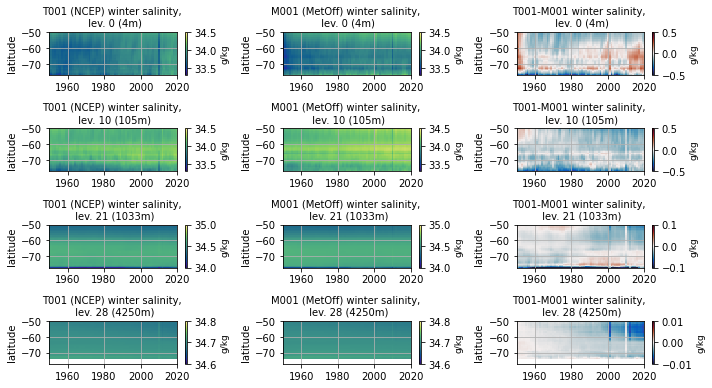

In [123]:
pbl = [T001_vosaline_wint, M001_vosaline_wint,T001_vosaline_wint-M001_vosaline_wint,
      T001_vosaline_wint, M001_vosaline_wint,T001_vosaline_wint-M001_vosaline_wint,
      T001_vosaline_wint, M001_vosaline_wint,T001_vosaline_wint-M001_vosaline_wint,
      T001_vosaline_wint, M001_vosaline_wint,T001_vosaline_wint-M001_vosaline_wint,
      T001_vosaline_wint, M001_vosaline_wint,T001_vosaline_wint-M001_vosaline_wint]
depths = [ 0,0,0,10,10,10,21,21,21,28,28,28]
mod1 = 'T001 (NCEP)'; mod2 = 'M001 (MetOff)'; diftit = 'T001-M001'
season = 'winter'; var = 'salinity'; labs = 'g/kg'
mins = [33.3,33.3,-0.5,
        33.3,33.3,-0.5,
        34,34,-0.1,
        34.6,34.6,-0.01]
maxs = [34.5,34.5,0.5,
        34.5,34.5,0.5,
        35,35,0.1,
        34.8,34.8,0.01]
cms = cm.haline

figmaker(pbl,depths,mod1,mod2,diftit,season,var,labs,mins,maxs,cms)

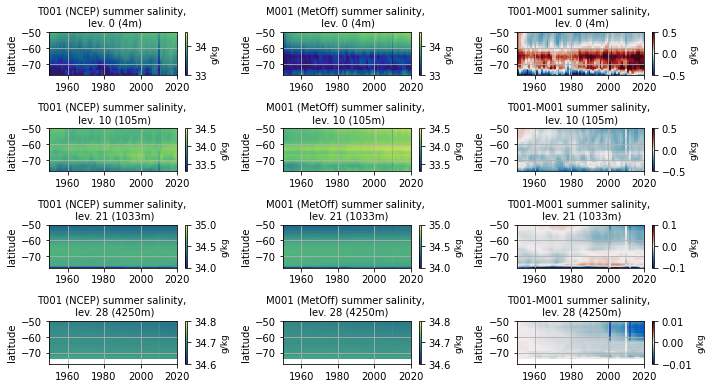

In [124]:
pbl = [T001_vosaline_sum, M001_vosaline_sum,T001_vosaline_sum-M001_vosaline_sum,
      T001_vosaline_sum, M001_vosaline_sum,T001_vosaline_sum-M001_vosaline_sum,
      T001_vosaline_sum, M001_vosaline_sum,T001_vosaline_sum-M001_vosaline_sum,
      T001_vosaline_sum, M001_vosaline_sum,T001_vosaline_sum-M001_vosaline_sum,
      T001_vosaline_sum, M001_vosaline_sum,T001_vosaline_sum-M001_vosaline_sum]
depths = [ 0,0,0,10,10,10,21,21,21,28,28,28]
mod1 = 'T001 (NCEP)'; mod2 = 'M001 (MetOff)'; diftit = 'T001-M001'
season = 'summer'; var = 'salinity'; labs = 'g/kg'
mins = [33.0,33.0,-0.5,
        33.3,33.3,-0.5,
        34,34,-0.1,
        34.6,34.6,-0.01]
maxs = [34.5,34.5,0.5,
        34.5,34.5,0.5,
        35,35,0.1,
        34.8,34.8,0.01]
cms = cm.haline

figmaker(pbl,depths,mod1,mod2,diftit,season,var,labs,mins,maxs,cms)

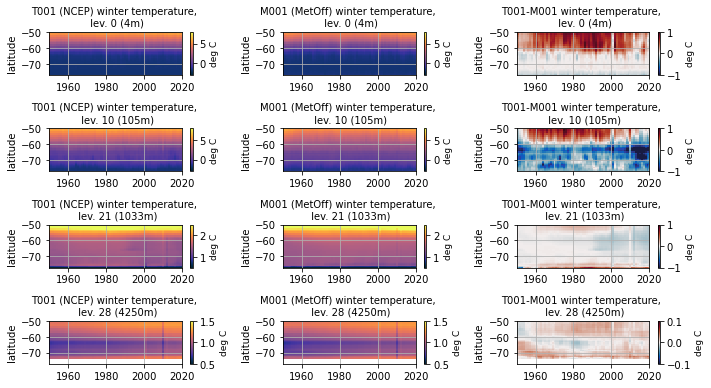

In [125]:
pbl = [T001_votemper_wint, M001_votemper_wint,T001_votemper_wint-M001_votemper_wint,
      T001_votemper_wint, M001_votemper_wint,T001_votemper_wint-M001_votemper_wint,
      T001_votemper_wint, M001_votemper_wint,T001_votemper_wint-M001_votemper_wint,
      T001_votemper_wint, M001_votemper_wint,T001_votemper_wint-M001_votemper_wint,
      T001_votemper_wint, M001_votemper_wint,T001_votemper_wint-M001_votemper_wint]
depths = [ 0,0,0,10,10,10,21,21,21,28,28,28]
mod1 = 'T001 (NCEP)'; mod2 = 'M001 (MetOff)'; diftit = 'T001-M001'
season = 'winter'; var = 'temperature'; labs = 'deg C'
l1mn = -3; l1mx = 8; l1mnd = -1; l1mxd = 1
l2mn = -3; l2mx = 8; l2mnd = -1; l2mxd = 1
l3mn = 0.5; l3mx = 2.5; l3mnd = -1; l3mxd = 1
l4mn = 0.5; l4mx = 1.5; l4mnd = -0.1; l4mxd = 0.1
mins = [l1mn, l1mn, l1mnd, l2mn, l2mn, l2mnd,\
        l3mn, l3mn, l3mnd, l4mn, l4mn, l4mnd]
maxs = [l1mx, l1mx, l1mxd, l2mx, l2mx, l2mxd,\
        l3mx, l3mx, l3mxd, l4mx, l4mx, l4mxd]        

cms = cm.thermal

figmaker(pbl,depths,mod1,mod2,diftit,season,var,labs,mins,maxs,cms)

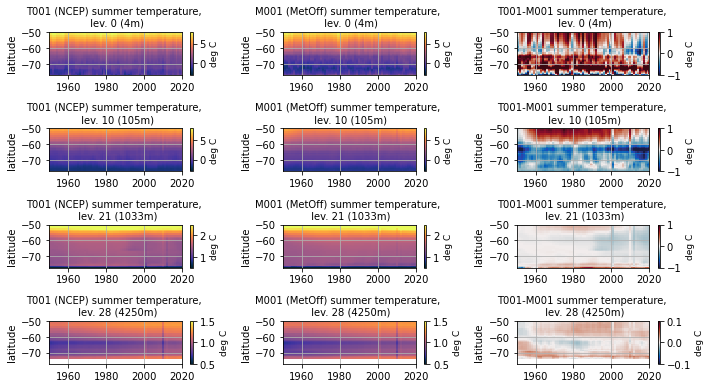

In [126]:
pbl = [T001_votemper_sum, M001_votemper_sum,T001_votemper_sum-M001_votemper_sum,
      T001_votemper_sum, M001_votemper_sum,T001_votemper_sum-M001_votemper_sum,
      T001_votemper_sum, M001_votemper_sum,T001_votemper_sum-M001_votemper_sum,
      T001_votemper_sum, M001_votemper_sum,T001_votemper_sum-M001_votemper_sum,
      T001_votemper_sum, M001_votemper_sum,T001_votemper_sum-M001_votemper_sum]
depths = [ 0,0,0,10,10,10,21,21,21,28,28,28]
mod1 = 'T001 (NCEP)'; mod2 = 'M001 (MetOff)'; diftit = 'T001-M001'
season = 'summer'; var = 'temperature'; labs = 'deg C'
l1mn = -3; l1mx = 8; l1mnd = -1; l1mxd = 1
l2mn = -3; l2mx = 8; l2mnd = -1; l2mxd = 1
l3mn = 0.5; l3mx = 2.5; l3mnd = -1; l3mxd = 1
l4mn = 0.5; l4mx = 1.5; l4mnd = -0.1; l4mxd = 0.1
mins = [l1mn, l1mn, l1mnd, l2mn, l2mn, l2mnd,\
        l3mn, l3mn, l3mnd, l4mn, l4mn, l4mnd]
maxs = [l1mx, l1mx, l1mxd, l2mx, l2mx, l2mxd,\
        l3mx, l3mx, l3mxd, l4mx, l4mx, l4mxd]        

cms = cm.thermal

figmaker(pbl,depths,mod1,mod2,diftit,season,var,labs,mins,maxs,cms)

In [ ]:
pbl = [T001_DIC_wint*1e6, M001_DIC_wint*1e6,T001_DIC_wint*1e6-M001_DIC_wint*1e6,
      T001_DIC_wint*1e6, M001_DIC_wint*1e6,T001_DIC_wint*1e6-M001_DIC_wint*1e6,
      T001_DIC_wint*1e6, M001_DIC_wint*1e6,T001_DIC_wint*1e6-M001_DIC_wint*1e6,
      T001_DIC_wint*1e6, M001_DIC_wint*1e6,T001_DIC_wint*1e6-M001_DIC_wint*1e6,
      T001_DIC_wint*1e6, M001_DIC_wint*1e6,T001_DIC_wint*1e6-M001_DIC_wint*1e6]

depths = [ 0,0,0,10,10,10,21,21,21,28,28,28]
mod1 = 'T001 (NCEP)'; mod2 = 'M001 (MetOff)'; diftit = 'T001-M001'
season = 'winter'; var = 'DIC'; labs = 'umol/L'
l1mn = 2100; l1mx = 2350; l1mnd = -100; l1mxd = 100
l2mn = 2100; l2mx = 2350; l2mnd = -100; l2mxd = 100
l3mn = 2200; l3mx = 2440; l3mnd = -50; l3mxd = 50
l4mn = 2400; l4mx = 2450; l4mnd = -10; l4mxd = 10
mins = [l1mn, l1mn, l1mnd, l2mn, l2mn, l2mnd,\
        l3mn, l3mn, l3mnd, l4mn, l4mn, l4mnd]
maxs = [l1mx, l1mx, l1mxd, l2mx, l2mx, l2mxd,\
        l3mx, l3mx, l3mxd, l4mx, l4mx, l4mxd]        

cms = cm.dense

figmaker(pbl,depths,mod1,mod2,diftit,season,var,labs,mins,maxs,cms)

In [ ]:
pbl = [T001_DIC_sum*1e6, M001_DIC_sum*1e6,T001_DIC_sum*1e6-M001_DIC_sum*1e6,
      T001_DIC_sum*1e6, M001_DIC_sum*1e6,T001_DIC_sum*1e6-M001_DIC_sum*1e6,
      T001_DIC_sum*1e6, M001_DIC_sum*1e6,T001_DIC_sum*1e6-M001_DIC_sum*1e6,
      T001_DIC_sum*1e6, M001_DIC_sum*1e6,T001_DIC_sum*1e6-M001_DIC_sum*1e6,
      T001_DIC_sum*1e6, M001_DIC_sum*1e6,T001_DIC_sum*1e6-M001_DIC_sum*1e6]

depths = [ 0,0,0,10,10,10,21,21,21,28,28,28]
mod1 = 'T001 (NCEP)'; mod2 = 'M001 (MetOff)'; diftit = 'T001-M001'
season = 'summer'; var = 'DIC'; labs = 'umol/L'
l1mn = 2100; l1mx = 2350; l1mnd = -100; l1mxd = 100
l2mn = 2100; l2mx = 2350; l2mnd = -100; l2mxd = 100
l3mn = 2200; l3mx = 2440; l3mnd = -50; l3mxd = 50
l4mn = 2400; l4mx = 2450; l4mnd = -10; l4mxd = 10
mins = [l1mn, l1mn, l1mnd, l2mn, l2mn, l2mnd,\
        l3mn, l3mn, l3mnd, l4mn, l4mn, l4mnd]
maxs = [l1mx, l1mx, l1mxd, l2mx, l2mx, l2mxd,\
        l3mx, l3mx, l3mxd, l4mx, l4mx, l4mxd]        

cms = cm.dense

figmaker(pbl,depths,mod1,mod2,diftit,season,var,labs,mins,maxs,cms)

In [ ]:
print('compute complete: beep boop.')